<h1><center>BeerMart : RECOMMENDATION SYSTEM</center></h1>

## Problem Statment

- Crate a collaborative filtering recommentation system
    - Data preparation (tranformation, selction & EDA)
    - Model building (user based & item based)
    - Model compariasion

In [1]:
#Loading required libraries
%matplotlib inline

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

#importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlt
import seaborn as sns

In [2]:
#Geting the data loaded to pandas dataframe
file_path = './beer_data.csv'
data = pd.read_csv(file_path)
data.shape

(475984, 3)

In [3]:
#Checking the data using head() method
data.head()

,beer_beerid,review_profilename,review_overall
0,48215,stcules,3.0
1,52159,oline73,3.0
2,52159,alpinebryant,3.0
3,52159,rawthar,4.0
4,52159,RangerClegg,3.5


In [4]:
#Removing the duplicates using drop_duplicates() method
data_1 = data.drop_duplicates(subset= ['beer_beerid' , 'review_profilename'], keep="last")
data_1.shape

(474560, 3)

### Q: Figure out an appropriate value of N using EDA; this may not have one correct answer, but you should not choose beers that have an extremely low number of ratings.

In [5]:
#Creating a dataframe with beer review counts.
beer_review_counts = pd.DataFrame(data_1.pivot_table(index=['beer_beerid'], values = ['review_overall'],
                                                     aggfunc = {'review_overall' : len}))

In [6]:
#Sorting the counts asendig order.
beer_review_counts.sort_values("review_overall", axis = 0, ascending = True,inplace = True, na_position ='last')
beer_review_counts.reset_index(inplace= True)

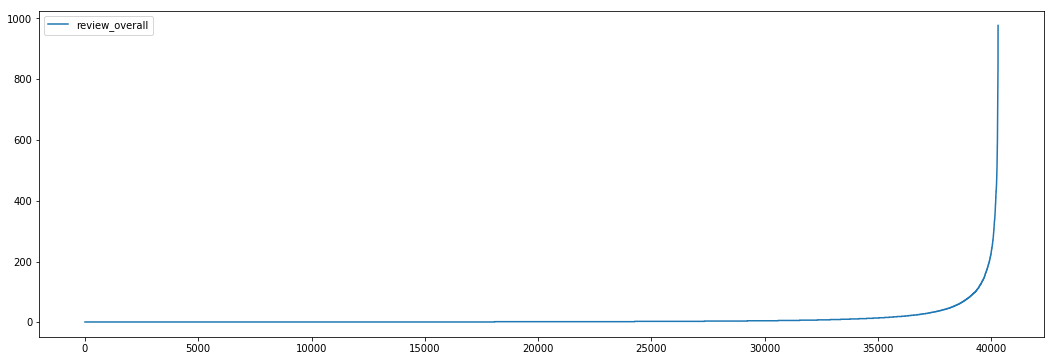

In [7]:
#Ploting the overall spread of the beer review counts
plt.figure(figsize=(18,6)) # 10 is width, 7 is height
plt.plot(beer_review_counts['review_overall'])  # green dots
plt.legend(loc='best')
plt.show()

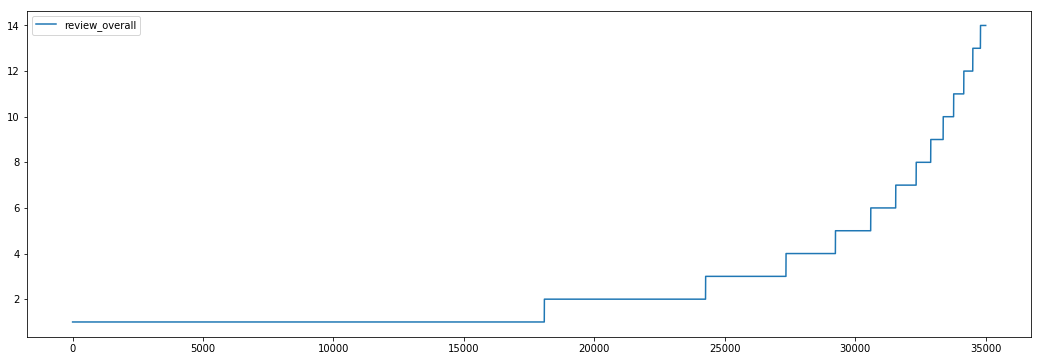

In [8]:
#Ploting the lower range of reviews to better decide the cut-off 
plt.figure(figsize=(18,6)) # 10 is width, 7 is height
plt.plot(beer_review_counts['review_overall'][:35000])  # green dots
plt.legend(loc='best')
plt.show()

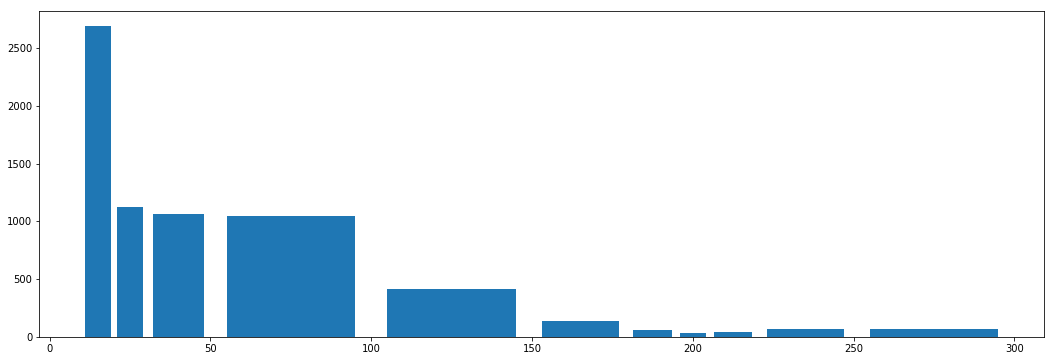

In [18]:
#Ploting histogram for better visibility of the lower range of beer review count upto 300
plt.figure(figsize=(18,6))
bins = [ 10, 20, 30, 50, 100, 150, 180, 195, 205, 220, 250, 300]
plt.hist(beer_review_counts['review_overall'], bins, rwidth=0.8)
plt.show()

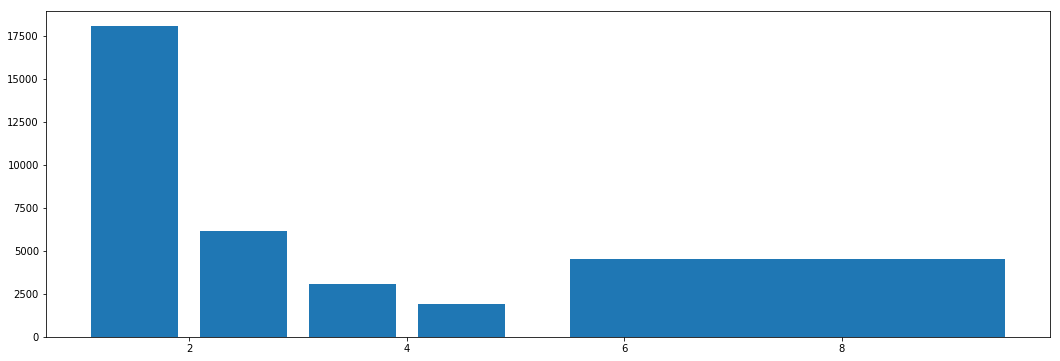

In [12]:
#Ploting histogram for better visibility of the lower range of beer review count upto 10
plt.figure(figsize=(18,6)) 
bins = [1, 2, 3, 4, 5, 10]
plt.hist(beer_review_counts['review_overall'], bins, rwidth=0.8)
plt.show()

### Based on the able plots, it cut of take an minimum 2 reviews. A separate dataset will be created witht he cut-off of 2 ratings minimum. In adition reffer the below rating counts also to back this cut-off.

### Q What are the unique values of ratings?

In [13]:
#Summrising the unique rating values & counts of the same
data_1.review_overall.value_counts()

4.0    174285
4.5     96966
3.5     90594
3.0     49422
5.0     27030
2.5     17568
2.0     11592
1.5      3810
1.0      3287
0.0         6
Name: review_overall, dtype: int64

### Rating range is from 0 to 5, with 0.5 intervel. Most number of ratings is 4 and the leaset are 0 to 1.5.

## Q: Visualise - The average beer ratings

In [14]:
#Getting the count of review with respect to the beer
beer_review_avg = pd.DataFrame(data_1.pivot_table(index=['beer_beerid'], values = ['review_overall'],
                                                     aggfunc = {'review_overall' : np.mean}))

In [15]:
#Sort review with respect to the beer rating counts
beer_review_avg.sort_values("review_overall", axis = 0, ascending = True,inplace = True, na_position ='last')
beer_review_avg.reset_index(inplace= True)

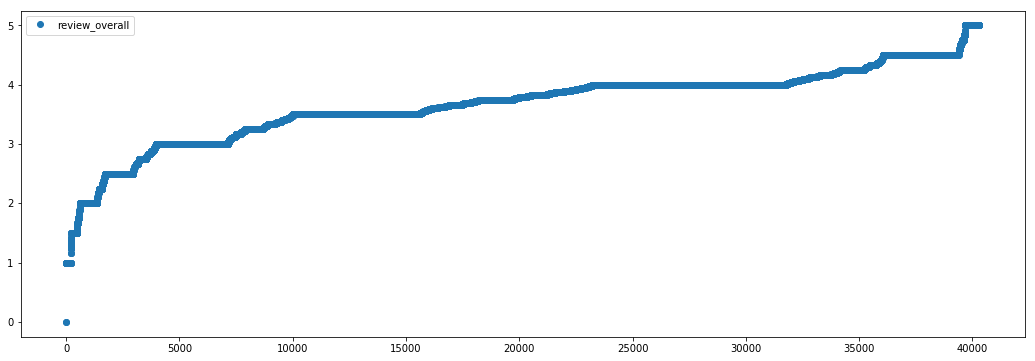

In [19]:
#Ploting the overall numbers of rating in asenting order
plt.figure(figsize=(18,6)) 
plt.plot(beer_review_avg['review_overall'],'o', linewidth=2)
plt.legend(loc='best')
plt.show()

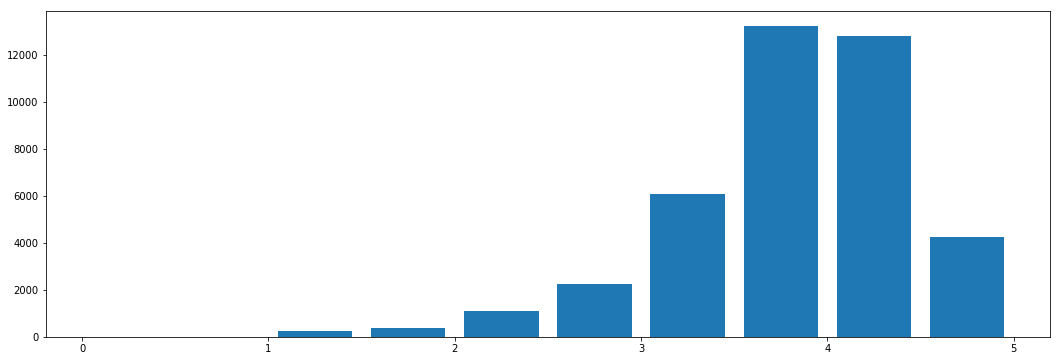

In [20]:
#Creating a histogram of review counts w.r.t beer
plt.figure(figsize=(18,6))
plt.hist(beer_review_avg['review_overall'], histtype='bar', rwidth=0.8)
plt.show()

## Q: Visualise - The average user ratings

In [21]:
#Create the rating counts w.r.t user.
user_review_avg = pd.DataFrame(data_1.pivot_table(index=['review_profilename'], values = ['review_overall'],
                                                     aggfunc = {'review_overall' : np.mean}))

In [22]:
#Sorting the user based rating count
user_review_avg.sort_values("review_overall", axis = 0, ascending = True,inplace = True, na_position ='last')
user_review_avg.reset_index(inplace= True)

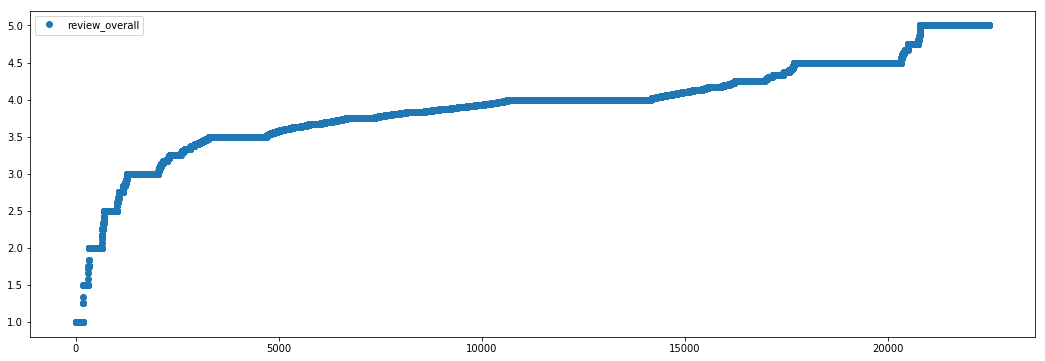

In [23]:
#Ploting the overall rating w.r.t user
plt.figure(figsize=(18,6)) 
plt.plot(user_review_avg['review_overall'],'o', linewidth=2)
plt.legend(loc='best')
plt.show()

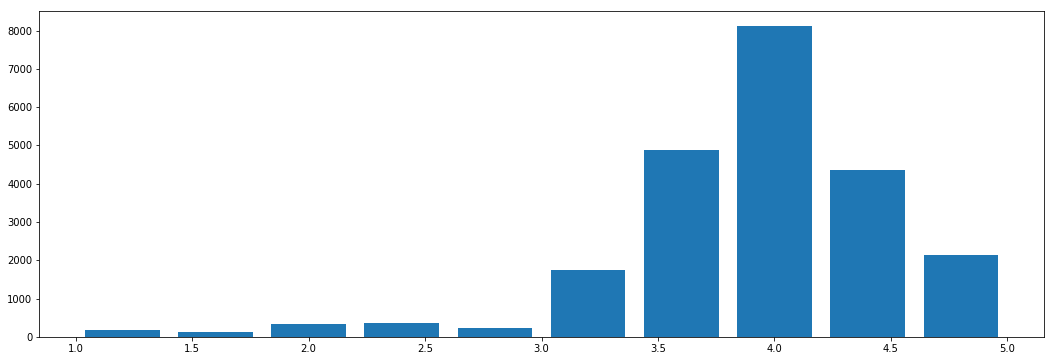

In [25]:
#Ploting histogram for the rating counts w.r.t user
plt.figure(figsize=(18,6)) 
plt.hist(user_review_avg['review_overall'],histtype='bar', rwidth=0.8)
plt.show()

### Observations
- Overall rating counts are centered around 4. Both in the case of user based & beer baseed
- There is no abnormal terend visible in the rating count
- 0-2 rating counts are less. For modeling greated than 2 reviews is considered

# Q: Recommendation Models

In [54]:
#Creating a list of beers to be removed from the data set, which have below 2 rating
beer_review_counts = pd.DataFrame(data_1.pivot_table(index=['beer_beerid'], values = ['review_overall'],
                                                     aggfunc = {'review_overall' : len}).reset_index())
beer_exclusion_list = list(beer_review_counts.loc[beer_review_counts['review_overall'] <= 2].beer_beerid)
len(beer_exclusion_list)

24261

In [95]:
#Creating a list of users to be removed from the data set, which have below 2 rating
user_review_counts = pd.DataFrame(data_1.pivot_table(index=['review_profilename'], values = ['review_overall'],
                                                     aggfunc = {'review_overall' : len}).reset_index())
user_exclusion_list = list(user_review_counts.loc[user_review_counts['review_overall'] <= 2].review_profilename)
len(user_exclusion_list)

10927

In [96]:
#Removing the beer ids not required for the evaluations
data_2 = data_1[~data_1.beer_beerid.isin(beer_exclusion_list)]
data_2.shape

(444118, 3)

In [97]:
#Removing the user ids not required for the evaluations
data_3 = data_2[~data_2.review_profilename.isin(user_exclusion_list)]
data_3.shape

(430832, 3)

In [98]:
print('% data remaining = ' + str((data_3.shape[0]/data_1.shape[0])*100))

% data remaining = 90.78556979096426


In [99]:
#Test- Train Split

In [100]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_3, test_size=0.30, random_state=31)

In [101]:
print(train.shape)
print(test.shape)

(301582, 3)
(129250, 3)


In [102]:
# pivot ratings into beer features
df_beer_features = train.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).fillna(0)

In [103]:
df_beer_features.head()

beer_beerid,4,5,6,7,8,9,10,11,12,13,...,76549,76571,76644,76671,76710,76775,76816,76840,76886,76892
review_profilename,,,,,,,,,,,,,,,,,,,,,
NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0beerguy0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0tt0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
#dummy Data set creation for future use
dummy_train = train.copy()
dummy_test = test.copy()

dummy_train['review_overall'] = dummy_train['review_overall'].apply(lambda x: 0 if x>=1 else 1)
dummy_test['review_overall'] = dummy_test['review_overall'].apply(lambda x: 1 if x>=1 else 0)

In [105]:
# The beers not rated by user is marked as 1 for prediction. 
dummy_train = dummy_train.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).fillna(1)

# The beers not rated by user is marked as 0 for evaluation. 
dummy_test = dummy_test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).fillna(0)

In [106]:
dummy_train.head()

beer_beerid,4,5,6,7,8,9,10,11,12,13,...,76549,76571,76644,76671,76710,76775,76816,76840,76886,76892
review_profilename,,,,,,,,,,,,,,,,,,,,,
NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0110x011,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
05Harley,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0beerguy0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0tt0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [107]:
dummy_test.head()

beer_beerid,4,5,6,7,8,9,10,11,12,13,...,76521,76525,76549,76571,76644,76710,76775,76816,76840,76892
review_profilename,,,,,,,,,,,,,,,,,,,,,
NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0tt0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000Bottles,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
#Transformtation

In [109]:
#Using Consine Similarity
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
user_correlation = 1 - pairwise_distances(df_beer_features, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1.         0.05849934 0.03079764 ... 0.02627284 0.         0.        ]
 [0.05849934 1.         0.04100324 ... 0.         0.         0.        ]
 [0.03079764 0.04100324 1.         ... 0.         0.         0.        ]
 ...
 [0.02627284 0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [110]:
user_correlation.shape

(11500, 11500)

In [111]:
#Using Adjusted Consine Similarity
beer_features = train.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

In [112]:
beer_features.head()

beer_beerid,4,5,6,7,8,9,10,11,12,13,...,76549,76571,76644,76671,76710,76775,76816,76840,76886,76892
review_profilename,,,,,,,,,,,,,,,,,,,,,
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0110x011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
05Harley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0beerguy0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0tt0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
#Normalizing the rating of the beer for each user aroung 0 mean
mean = np.nanmean(beer_features, axis=1)
df_subtracted = (beer_features.T-mean).T

In [114]:
df_subtracted.head()

beer_beerid,4,5,6,7,8,9,10,11,12,13,...,76549,76571,76644,76671,76710,76775,76816,76840,76886,76892
review_profilename,,,,,,,,,,,,,,,,,,,,,
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0110x011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
05Harley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0beerguy0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0tt0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
#Finding the cosine similarity
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[ 1.          0.         -0.01669283 ...  0.10553342  0.
   0.        ]
 [ 0.          1.         -0.01590523 ...  0.          0.
   0.        ]
 [-0.01669283 -0.01590523  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.10553342  0.          0.         ...  1.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          1.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]


In [116]:
#Predictions
user_correlation[user_correlation<0]=0
user_correlation

array([[1.        , 0.        , 0.        , ..., 0.10553342, 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.10553342, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [117]:
user_predicted_ratings = np.dot(user_correlation, beer_features.fillna(0))
user_predicted_ratings

array([[3.30896789e-01, 3.43599937e+00, 8.38757364e+00, ...,
        0.00000000e+00, 2.81413958e-04, 0.00000000e+00],
       [6.38195148e-03, 8.30269393e-01, 1.98395616e+00, ...,
        0.00000000e+00, 6.47201204e-02, 0.00000000e+00],
       [0.00000000e+00, 1.29518178e+00, 1.75837356e+00, ...,
        0.00000000e+00, 2.70397775e-02, 3.38958423e-01],
       ...,
       [4.04426128e-02, 2.52335957e+00, 5.31971968e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.55093294e-01, 4.91712359e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [118]:
user_predicted_ratings.shape

(11500, 15915)

In [119]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

beer_beerid,4,5,6,7,8,9,10,11,12,13,...,76549,76571,76644,76671,76710,76775,76816,76840,76886,76892
review_profilename,,,,,,,,,,,,,,,,,,,,,
NaN,0.330897,3.435999,8.387574,6.068992,0.595293,0.863178,6.876393,0.952069,1.466462,0.790277,...,0.08696,0.442194,0.162374,0.106144,0.34037,0.000000,0.702635,0.0,0.000281,0.000000
0110x011,0.006382,0.830269,1.983956,1.669823,0.146552,0.220469,2.968388,0.188304,0.303342,0.264640,...,0.00000,0.007888,0.471688,0.113098,0.01322,0.118234,0.107730,0.0,0.064720,0.000000
05Harley,0.000000,1.295182,1.758374,1.503476,0.024072,0.224983,1.799260,0.144131,0.349882,0.348306,...,0.00000,0.046939,0.207253,0.180324,0.00000,0.042875,0.184592,0.0,0.027040,0.338958
0beerguy0,0.000000,0.283291,0.945702,1.578780,0.623835,0.044686,2.507855,0.295834,0.229692,0.019816,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000
0tt0,0.000000,1.800687,3.750573,2.603754,0.314868,0.585651,5.144172,0.143930,0.417609,0.325611,...,0.00000,0.012918,0.000000,0.537019,0.00000,0.141211,0.851582,0.0,0.271285,0.000000


In [120]:
#Finding to 10 recommentatin for user 1
user_final_rating.iloc[1].sort_values(ascending=False)[0:10]

beer_beerid
7971     15.270923
412      13.781429
17112    13.533972
19960    13.426456
11757    12.996676
645      12.387100
1904     10.569639
1444     10.394010
1160     10.315781
34420    10.215868
Name: 0110x011, dtype: float64

### Item Based Similarity

In [121]:
beer_features = train.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).T

beer_features.head()

review_profilename,nan,0110x011,05Harley,0beerguy0,0tt0,1000Bottles,100floods,1099,1121987,11millsown113,...,zplug123,zrab11,zseeanz,ztaylor1,zuffenhausen,zuggy9,zwan,zymurgy4all,zythus,zyzygy
beer_beerid,,,,,,,,,,,,,,,,,,,,,
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
# Normalising the beer rating for each beer
mean = np.nanmean(beer_features, axis=1)
df_subtracted = (beer_features.T-mean).T

In [123]:
df_subtracted.head()

review_profilename,nan,0110x011,05Harley,0beerguy0,0tt0,1000Bottles,100floods,1099,1121987,11millsown113,...,zplug123,zrab11,zseeanz,ztaylor1,zuffenhausen,zuggy9,zwan,zymurgy4all,zythus,zyzygy
beer_beerid,,,,,,,,,,,,,,,,,,,,,
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.01163016 ... 0.         0.         0.        ]
 [0.         0.01163016 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [125]:
item_correlation[item_correlation<0]=0
item_correlation

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.01163016, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01163016, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [126]:
#Prediction
item_predicted_ratings = np.dot((beer_features.fillna(0).T),item_correlation)
item_predicted_ratings

array([[1.12277567, 1.52497387, 1.4973745 , ..., 0.        , 0.24396012,
        0.        ],
       [0.38474204, 0.39273708, 1.25330259, ..., 0.        , 0.40981714,
        0.        ],
       [0.        , 0.85580002, 0.7023852 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.53651482, 0.88332138, 0.91344502, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.06783123, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.40063338, 0.        , 0.12775631, ..., 0.        , 0.        ,
        0.        ]])

In [127]:
item_predicted_ratings.shape

(11500, 15915)

In [128]:
dummy_train.shape

(11500, 15915)

In [129]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

beer_beerid,4,5,6,7,8,9,10,11,12,13,...,76549,76571,76644,76671,76710,76775,76816,76840,76886,76892
review_profilename,,,,,,,,,,,,,,,,,,,,,
NaN,1.122776,1.524974,1.497374,1.642977,0.936347,1.333443,1.822833,1.350928,2.035800,1.938827,...,0.0,0.647176,0.0,0.451412,0.0,0.0,0.491781,0.0,0.243960,0.0
0110x011,0.384742,0.392737,1.253303,1.209724,0.350477,0.481081,0.971595,0.275673,0.353589,0.456484,...,0.0,0.284760,0.0,0.238627,0.0,0.0,0.111762,0.0,0.409817,0.0
05Harley,0.000000,0.855800,0.702385,0.890604,0.456696,0.470934,1.038879,0.331552,0.277638,0.275943,...,0.0,0.164006,0.0,0.332907,0.0,0.0,0.141154,0.0,0.000000,0.0
0beerguy0,0.000000,0.185591,0.060822,0.067995,0.016318,0.020443,0.143702,0.375061,0.058718,0.076997,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.003032,0.0,0.000000,0.0
0tt0,0.252469,0.317333,0.601740,0.174192,0.063197,0.367971,0.545758,0.138093,0.413213,0.811604,...,0.0,0.043302,0.0,0.471455,0.0,0.0,0.157693,0.0,0.165199,0.0


In [130]:
#Top 10 prediciton for the user1
item_final_rating.iloc[1].sort_values(ascending=False)[0:10]

beer_beerid
3414     3.386536
11894    3.156494
8239     3.142696
40313    3.108793
59929    3.082144
38016    3.074628
35198    3.036775
22076    3.000112
3314     2.932499
6624     2.915509
Name: 0110x011, dtype: float64

### Evaluation

In [132]:
#using User Similarity
test_beer_features = test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)
mean = np.nanmean(test_beer_features, axis=1)
test_df_subtracted = (test_beer_features.T-mean).T

# User Similarity Matrix
test_user_correlation = 1 - pairwise_distances(test_df_subtracted.fillna(0), metric='cosine')
test_user_correlation[np.isnan(test_user_correlation)] = 0
print(test_user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [133]:
test_user_correlation[test_user_correlation<0]=0
test_user_predicted_ratings = np.dot(test_user_correlation, test_beer_features.fillna(0))
test_user_predicted_ratings

array([[0.        , 0.81865558, 2.1725364 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.12376618, 0.98945849, ..., 0.0444232 , 0.00285231,
        0.        ],
       [0.        , 0.04346361, 1.08192446, ..., 0.        , 0.        ,
        0.23488185],
       ...,
       [0.30407922, 0.2220907 , 1.11776417, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [134]:
#Doing prediciton for the beer rated by the user
test_user_final_rating = np.multiply(test_user_predicted_ratings,dummy_test)

In [135]:
test_user_final_rating.head()

beer_beerid,4,5,6,7,8,9,10,11,12,13,...,76521,76525,76549,76571,76644,76710,76775,76816,76840,76892
review_profilename,,,,,,,,,,,,,,,,,,,,,
NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0tt0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000Bottles,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
#Calculating the RMSE for only the beer rated by user. 
#For RMSE, normalising the rating to (1,5) range
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = test_user_final_rating.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(copy=True, feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [137]:
test_ = test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

In [138]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [139]:
rmse = (sum(sum((test_ - y )**2))/total_non_nan)**0.5
print(rmse)

1.885351811035956


In [140]:
#Using Item Similarity
test_beer_features = test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).T

mean = np.nanmean(test_beer_features, axis=1)
test_df_subtracted = (test_beer_features.T-mean).T

test_item_correlation = 1 - pairwise_distances(test_df_subtracted.fillna(0), metric='cosine')
test_item_correlation[np.isnan(test_item_correlation)] = 0
test_item_correlation[test_item_correlation<0]=0

In [141]:
test_item_correlation.shape

(13966, 13966)

In [142]:
test_beer_features.shape

(13966, 10344)

In [143]:
test_item_predicted_ratings = (np.dot(test_item_correlation, test_beer_features.fillna(0))).T
test_item_final_rating = np.multiply(test_item_predicted_ratings,dummy_test)
test_item_final_rating.head()

beer_beerid,4,5,6,7,8,9,10,11,12,13,...,76521,76525,76549,76571,76644,76710,76775,76816,76840,76892
review_profilename,,,,,,,,,,,,,,,,,,,,,
NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0tt0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000Bottles,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
test_ = test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

In [145]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = test_item_final_rating.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))


test_ = test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

MinMaxScaler(copy=True, feature_range=(1, 5))


In [146]:
rmse = (sum(sum((test_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.322552026049193


### User similarity is better since the RMSE is lesser

### Q.  Give the names of the top 5 beers that you would recommend to the users 'cokes', 'genog' and 'giblet' using both the models.

- The top 5 beers that you would recommend to the users 'cokes' using User based model

In [242]:
userBasedPrediction = test_user_final_rating.reset_index()

coke_prediction = pd.DataFrame(
    userBasedPrediction.loc[userBasedPrediction['review_profilename'] == 'cokes']).T.reset_index()

coke_prediction.rename(columns={"beer_beerid": "Beer", 5530: "User_Rating"}, inplace= True)

coke_prediction_1 = pd.DataFrame(coke_prediction[~coke_prediction.User_Rating.isin([NaN])])
coke_prediction_2 = pd.DataFrame(coke_prediction_1[~coke_prediction_1.User_Rating.isin(['cokes'])])

coke_prediction_2.sort_values('User_Rating', axis = 0, ascending = False)[:5]

,Beer,User_Rating
461,731,26.7719
691,1118,20.8542
78,104,15.7408
153,225,13.4038
3359,7520,10.0379


- The top 5 beers that you would recommend to the users 'genog' using User based model

In [243]:
coke_prediction = pd.DataFrame(
    userBasedPrediction.loc[userBasedPrediction['review_profilename'] == 'genog']).T.reset_index()
coke_prediction.rename(columns={"beer_beerid": "Beer", 6404: "User_Rating"}, inplace= True)

coke_prediction_1 = pd.DataFrame(coke_prediction[~coke_prediction.User_Rating.isin([NaN])])
coke_prediction_2 = pd.DataFrame(coke_prediction_1[~coke_prediction_1.User_Rating.isin(['genog'])])

coke_prediction_2.sort_values('User_Rating', axis = 0, ascending = False)[:5]

,Beer,User_Rating
66,88,35.0975
798,1320,26.428
9301,42533,23.4019
417,674,14.5807
5009,15813,14.135


- The top 5 beers that you would recommend to the users 'giblet' using User based model

In [244]:
coke_prediction = pd.DataFrame(
    userBasedPrediction.loc[userBasedPrediction['review_profilename'] == 'giblet']).T.reset_index()
coke_prediction.rename(columns={"beer_beerid": "Beer", 6436: "User_Rating"}, inplace= True)

coke_prediction_1 = pd.DataFrame(coke_prediction[~coke_prediction.User_Rating.isin([NaN])])
coke_prediction_2 = pd.DataFrame(coke_prediction_1[~coke_prediction_1.User_Rating.isin(['giblet'])])

coke_prediction_2.sort_values('User_Rating', axis = 0, ascending = False)[:5]

,Beer,User_Rating
433,695,53.5226
5219,17112,51.3254
395,645,44.9447
193,276,33.8989
1136,1867,14.0736


-The top 5 beers that you would recommend to the users 'cokes' using Item based model

In [246]:
ItemBasedPrediction = test_item_final_rating.reset_index()

coke_prediction = pd.DataFrame(
    ItemBasedPrediction.loc[userBasedPrediction['review_profilename'] == 'cokes']).T.reset_index()

coke_prediction.rename(columns={"beer_beerid": "Beer", 5530: "User_Rating"}, inplace= True)

coke_prediction_1 = pd.DataFrame(coke_prediction[~coke_prediction.User_Rating.isin([NaN])])
coke_prediction_2 = pd.DataFrame(coke_prediction_1[~coke_prediction_1.User_Rating.isin(['cokes'])])

coke_prediction_2.sort_values('User_Rating', axis = 0, ascending = False)[:5]

,Beer,User_Rating
1118,1835,86.8659
3632,8511,85.9768
2807,5822,83.0867
7139,29219,75.8987
3080,6666,72.4941


In [249]:
ItemBasedPrediction = test_item_final_rating.reset_index()

coke_prediction = pd.DataFrame(
    ItemBasedPrediction.loc[userBasedPrediction['review_profilename'] == 'genog']).T.reset_index()

coke_prediction.rename(columns={"beer_beerid": "Beer", 6404: "User_Rating"}, inplace= True)

coke_prediction_1 = pd.DataFrame(coke_prediction[~coke_prediction.User_Rating.isin([NaN])])
coke_prediction_2 = pd.DataFrame(coke_prediction_1[~coke_prediction_1.User_Rating.isin(['genog'])])

coke_prediction_2.sort_values('User_Rating', axis = 0, ascending = False)[:5]

,Beer,User_Rating
1222,2010,6.3384
8741,39514,6.27445
7012,28350,6.01555
417,674,5.91189
9301,42533,5.77677


In [252]:
ItemBasedPrediction = test_item_final_rating.reset_index()

coke_prediction = pd.DataFrame(
    ItemBasedPrediction.loc[userBasedPrediction['review_profilename'] == 'giblet']).T.reset_index()

coke_prediction.rename(columns={"beer_beerid": "Beer", 6436: "User_Rating"}, inplace= True)

coke_prediction_1 = pd.DataFrame(coke_prediction[~coke_prediction.User_Rating.isin([NaN])])
coke_prediction_2 = pd.DataFrame(coke_prediction_1[~coke_prediction_1.User_Rating.isin(['giblet'])])

coke_prediction_2.sort_values('User_Rating', axis = 0, ascending = False)[:5]

,Beer,User_Rating
5562,19425,6.44664
5355,17805,6.31485
1966,3535,5.35698
5582,19589,5.19715
395,645,5.07006


<h1><center>THE END</center></h1>

<h1><center>Thank You..!</center></h1>